## Introduction to Deep Learning
# Part 3 - Multiple Layer Neural Networks
### Delta rule for learning, Gradient Decent and backpropogation

In [234]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss
%matplotlib inline  

Networks without hidden units are very limited in what they can learn to model. What we need is multiple layers of non-linear hidden units. <br>
The challenge is: **how to train such networks ?**<br>
We need a way to update all the weights not just the last layer like in a perceptron. It is a hard problem, and it took the researchers 20 years to find the right method. <br>


![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/training_model.png)
Any hidden unit, can affect many other units, and affect the results, in many ways. So we use a method to combine all those effects, and focus on investigating the effect, the weight have, on the overall error.<br>

The aim of the learning is to minimize the error summed (or mean) over all training cases. <br>
To achieve that,we need a **measure** of that error. For simplicity, we will use the square difference between the target output and the actual output. 

### Loss Function For learning
The squared loss is a popular loss function, also known as L2 loss.The squared loss is the squared distance between the prediction and the true label. <br>
Lets mark:
* $x\, -\, The\, input$
* $\hat{y}\, or \,y'\, - \,The\, true\, labels$<br>
* $y = predictions(x) = f(x)\; Model's\,  predictions$<br>

The squared loss for a single example is: ${(\hat{y} - y)}^2$<br>

 
#### Mean square error (MSE) 
is the average squared loss per example over the whole dataset. 
To calculate MSE, sum up all the squared
losses for individual examples and then divide by the number of examples:
    $$ MSE = \frac{1}{N} \sum_{(x,y)\in D} (\hat{y} - f(x))^2 = \frac{1}{N} \sum_{(x,y)\in D} (\hat{y} - y)^2$$
> MSE is popular in machine learning, mainly from historical reasons, since all the math was initially calculated with MSE. But it is not necessary the best. For different problems, there are other practical loss functions that performs better.

#### The goal of training a model is to find a set of weights that produce a minimal loss, on average, across all examples.


To find the minimum of the loss function, we will use An iterative method. <br>
Iterative methods, are usually less efficient, but much easier to generalize.

## Gradient Decent - Minimize loss function iterativly 
Intuition: Imagine you stand in a canyon, or a bowl, and you want to get to the lowest point. If you walk in small steps towards the steepest part, this will get you to the lowest point, if the canyon (or the bowl) is convex.
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/dune11.jpg)
### Delta rule for learning
This intuition is defined as the delta rule.
$$ \Delta{W} = \alpha*(derivative\, of\, the \,loss\, function)$$

* $\alpha$ - learning rate, is the (small) size of the step.

The weights update will be:
$$ W_{new} = W_{old} - \Delta{W}$$



But how do we implement the delta rule for a multi layer network ?
This implementation is called back-propagation. Back-propagation, is an abbreviation for **"backwards propagation of errors"**, is a mechanism used to update the weights using gradient descent. It calculates the gradient of the error function with respect to the neural networks weights. The calculation proceeds backwards through the network.

## Back-propagation
Back propagation,is a method to propagate the error, back to the weights, and update them in away that will minimize the error.<br>
Math is simple algebra, but there are some indexing to follow. The coded is illustrative, specific and not too general. Still you can play with it and test different hyper parameters and data sets.<br>
### Multiple Layer Neural Networks example
To implement full back-propagation example, Lets build a simple neural network, with:
* One hidden layer, with 2 neurons
* Input layer of 2 feature and bias
* Output layer, outputs probability of binary classification (the probability to be 1)

![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/mlp1j11.JPG)
#### Activation function
For simplicity, we choose all activation functions to be Sigmoid function.

* $z$ - will be the weighted input sum of the input to the neuron
* $y$ - will be the output of the neuron, which is the Sigmoid(z).
* I - the input to the neuron
* W - the neurons weights (same number as inputs)

##### The Neuron 
All Neurons in our network, calculate weighted sum of the input, and output the results of applying Sigmoid function on the weighted sum.
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/neuron_in_out.JPG)
### Build MLP Step 1. Initialize network
We define the network as a dictionary, holding weights of each neuron, z values (the weighted sum) and output values.

We Initialize network with random weights:

In [235]:
# Initialize a network
n_inputs = 3
n_hidden = 2

def initialize_mlp():
    
    mlp = {'n_inputs':n_inputs,'n_hidden':n_hidden,
        'n_outputs':1,
        'hidden_layer_weights':np.random.random((n_hidden, n_inputs)),
        
        'output_layer_weights':np.random.random(n_hidden),
        'output_layer_z':0.,
        'hidden_z':np.zeros(n_hidden),
        'hidden_out':np.zeros(n_hidden),
        'output_layer_out':0.
    }
    
    return mlp

In [236]:
def print_network(network):
    print('\033[1m'+'hidden_layer_weights:')
    
    for i in range(n_hidden):
        print('\033[0m'+'h{} weights:{}'.format(i, network['hidden_layer_weights'][i]))
        print('h{} z : {:.4f}'.format(i, network['hidden_z'][i]))
        print('h{} y : {:.4f}'.format(i, network['hidden_out'][i]))
    print('\033[1m'+'output_layer_weights:')
    print('\033[0m'+'o_weights: {}'.format(network['output_layer_weights']))
    print('output layer z : {:.4f}'.format(network['output_layer_z']))
    print('\033[1m'+'Output - y : {:.4f}'.format(network['output_layer_out']))
    print('\033[0m')

In [237]:

np.random.seed(0)
network = initialize_mlp()
print_network(network)

hidden_layer_weights:
h0 weights:[ 0.549  0.715  0.603]
h0 z : 0.0000
h0 y : 0.0000
h1 weights:[ 0.545  0.424  0.646]
h1 z : 0.0000
h1 y : 0.0000
output_layer_weights:
o_weights: [ 0.438  0.892]
output layer z : 0.0000
Output - y : 0.0000



### Step 2. Forward pass
Given an input, calculate the output. To do that, we calculate all the values in the neurons along the network, until the output.

In [238]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [239]:
# Forward pass: propagate input to a network output
def forward_propagate(network, inputs):
    #new_inputs = []
    for i in range(network['n_hidden']):

        network['hidden_z'][i] = np.dot(network['hidden_layer_weights'][i],
                                                inputs)
        network['hidden_out'][i] = sigmoid(network['hidden_z'][i])
    
   
    z = np.dot(network['output_layer_weights'], 
                 [network['hidden_out'][i] for i in range(n_hidden)])
    out = sigmoid(z)
    network['output_layer_z'] = z
    network['output_layer_out'] = out
    
    return out


In [240]:
# Forward pass: propagate input to a network output
def forward_propagate(network, X):
    
    # z_h = Wh*X
    network['hidden_z'] = np.dot(network['hidden_layer_weights'], X.T)
    # y_h = sigmoid(z_h)
    network['hidden_out'] = sigmoid(network['hidden_z'])
       
    # z_o = Wo* y_h
    network['output_layer_z'] = np.dot(network['output_layer_weights'], network['hidden_out'].T)
    # y_o = sigmoid(z_o)
    network['output_layer_out'] = sigmoid(network['output_layer_z'])
    
    return network['output_layer_out']


In [241]:
np.random.seed(0)
network = initialize_mlp()
output = forward_propagate(network, np.array([1, 0, 1]))
print_network(network)

hidden_layer_weights:
h0 weights:[ 0.549  0.715  0.603]
h0 z : 1.1516
h0 y : 0.7598
h1 weights:[ 0.545  0.424  0.646]
h1 z : 1.1908
h1 y : 0.7669
output_layer_weights:
o_weights: [ 0.438  0.892]
output layer z : 1.0164
Output - y : 0.7343



## Step 3. Back-propagation
To apply the delta rule for learning, we need to define a loss function. Lets use the simple known square error, for **one input sample**:
$$Error = \frac{1}{2}(\hat{y} - y)^2$$
where:
* $\hat{y}$ is the true label, y_train
* $y$ is the prediction calculated by the network

To update weights, according to delta rule, we need to calculate the "influence" of each weight on the target. Mathematically, we need to calculate the partial derivative of the error, with respect to each weight. <br>
Lets mark the weights in our network, and lets mark :
* $o$-output layer, and $h$-hidden layer
* $y_{o}$, and $y_{h}$ are the outputs from output and hidden layers
* $z_{o}$, and $z_{h}$ are the weighted sum of input and neuron weights, of the output and hidden layers.

![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/mlp_2hidden_1ou_weightst.jpg)

### Back-propagating error for output layer
Consider $w_1$, We want to know how much a change in $w_1$ affects the total error, aka, $\frac{\partial Error}{\partial w_{1}}$

Using chain rule, we will get:
$$\frac{\partial Error}{\partial w_{1}} = \frac{\partial Error}{\partial y_o} * 
\frac{\partial y_o}{\partial z_{o}} *
\frac{\partial z_{o}}{\partial w_{1}}$$

$$\frac{\partial Error}{\partial y_o} = 2 * \frac{1}{2}(\hat{y} - y_o)^{2 - 1} * -1 =(y_o-\hat{y})$$

We chose Sigmoid activation, which derivative is:
$$\frac{\partial}{\partial x}Sigmoid(x) = Sigmoid(x)(1 - Sigmoid(x))$$
* details https://beckernick.github.io/sigmoid-derivative-neural-network/

And since:




$$\hat{y} = y_o = \frac{1}{1+e^{-z_{o}}}$$
We get:

$$\frac{\partial y_o}{\partial z_{o}} = y_o*(1-y_o)$$

$$z_{o} = y_{h0}*w_0 + y_{h1}*w_1 = \bar{w_{o}} * \bar{y_h}$$    

$y_{h0}$ ho has no dependence in $w_{1}$, So:
$$\frac{\partial z_{o}}{\partial w_{1}} = y_{h1}$$    


Putting it all together, we get:

$$\frac{\partial Error}{\partial w_{1}} = \frac{\partial Error}{\partial y_o} * 
\frac{\partial y_o}{\partial z_{o}} *
\frac{\partial z_{o}}{\partial w_{1}} =  -(\hat{y}-y_o)*
y_o*(1-y_o)*
y_{h1}
$$

So according to delta rule, to decrease error, we update $w_1$:
$$w_1^{new} = w_1 - \alpha*\frac{\partial Error}{\partial w_{1}} = w_1 + \alpha* (\hat{y}-y_o)*  y_o*(1-y_o)*y_{h1}$$

In the same, we can calculate update for $w_0$:
$$w_0^{new} = w_0 + \alpha* (\hat{y}-y_o)*  y_o*(1-y_o)*y_{ho}$$

Lets mark:
$$ \delta_{i} = y_i*(1-y_i)$$

**We get an update rule for output layer weights:**
### $$w_0^{new} = w_0 + \alpha* \delta_{o}*y_{ho}*(\hat{y}-y_o)$$
### $$w_1^{new} = w_1 + \alpha* \delta_{o}*y_{h1}*(\hat{y}-y_o)$$
**Vector wise:**
### $$\bar{w}^{new} = \bar{w} + \alpha* \delta_{o}*\bar{y}_{h}*(\hat{y}-y_o)$$


### Back-propagating error for hidden layer
Now we need to continue one more layer back,to calculate the update of the weights.<br>

In a similar way, lets calculate: $\frac{\partial Error}{\partial w_{12}}$

$$\frac{\partial Error}{\partial w_{12}} = [\frac{\partial Error}{\partial y_{o}} * 
\frac{\partial y_{o}}{\partial z_{o}}] * 
\frac{\partial z_{o}}{\partial y_{h1}} * 
\frac{\partial y_{h1}}{\partial z_{h1}} *
\frac{\partial z_{h1}}{\partial w_{12}} $$

$$\frac{\partial Error}{\partial w_{12}} = -[\delta_{0}*y_{h1}*(\hat{y}-y_0)]*\frac{\partial z_{o}}{\partial y_{h1}} * 
\frac{\partial y_{h1}}{\partial z_{h1}} *
\frac{\partial z_{h1}}{\partial w_{12}} $$

$$z_{o} = y_{h_0}*w_0 + y_{h_1}*w_1 = \bar{z_h}*\bar{w_o}$$   

$$\frac{\partial z_{o}}{\partial y_{h1}} = w_1$$

$$\frac{\partial y_{h1}}{\partial z_{h1}} = y_{h1}*(1-y_{h1})=\delta_{h1}$$

$$\frac{\partial z_{h1}}{\partial w_{12}} = I_{2}$$

Putting it all together, we get:

$$\frac{\partial Error}{\partial w_{10}} = -(\hat{y}-y_o)*\delta_{o}*y_{h1}*w_1*\delta_{h1}*I_0$$

$$\frac{\partial Error}{\partial w_{11}} = -(\hat{y}-y_o)*\delta_{o}*y_{h1}*w_1*\delta_{h1}*I_1$$

$$\frac{\partial Error}{\partial w_{12}} = -(\hat{y}-y_o)*\delta_{o}*y_{h1}*w_1*\delta_{h1}*I_2$$

We can write, general update rule for hidden layer of our network:

$$\frac{\partial Error}{\partial w_{ij}} = -(\hat{y}-y_o)*\delta_{o}*y_{hi}*w_i*\delta_{hi}*I_j$$

**So, update rule for hidden layer weights, will be:**

### $$w^{new}_{ij} = w_{ij} + \alpha *(\hat{y}-y_o)*\delta_{o}*y_{hi}*w_i*\delta_{hi}*I_j$$

Pay attention to the order of update. We need to first update the hidden layer weights, then the output. Since all update calculation, depend on the values before the update.

In [242]:
def delta(out):    
    return out * (1 - out)

In [243]:
# Backpropagate error and update weights
def backward_propagate_error(network, I, y, y_true, lr = 0.5):

    for i in range(n_hidden):

        # calculate update for output layer weights
        update_i = delta(y) * network['hidden_out'][i] * (y_true - y)
               
        # update hidden layer weights        
        for j in range(n_inputs):
            w_i = network['output_layer_weights'][i]
            y_hi = network['hidden_out'][i]
            update_ij = update_i*w_i*delta(y_hi)*I[j]
            network['hidden_layer_weights'][i][j] += lr*update_ij
       
        # update output layer weights
        network['output_layer_weights'][i] +=  lr * update_i        

Let's Test of back propagation

In [244]:
np.random.seed(0)
network = initialize_mlp()

inputs = np.array([1,0,0])
target = 0
output = forward_propagate(network, inputs)
print('**Network after forward pass')
print_network(network)
backward_propagate_error(network, inputs, output, target)
print('\n**Network after forward pass and back propagation')
# perform forward pass toupdate z and out of neurons
output = forward_propagate(network, inputs)
print_network(network)

**Network after forward pass
hidden_layer_weights:
h0 weights:[ 0.549  0.715  0.603]
h0 z : 0.5488
h0 y : 0.6339
h1 weights:[ 0.545  0.424  0.646]
h1 z : 0.5449
h1 y : 0.6329
output_layer_weights:
o_weights: [ 0.438  0.892]
output layer z : 0.8418
Output - y : 0.6988


**Network after forward pass and back propagation
hidden_layer_weights:
h0 weights:[ 0.544  0.715  0.603]
h0 z : 0.5441
h0 y : 0.6328
h1 weights:[ 0.535  0.424  0.646]
h1 z : 0.5352
h1 y : 0.6307
output_layer_weights:
o_weights: [ 0.391  0.845]
output layer z : 0.7805
Output - y : 0.6858



We can see that the result, improved after weight update with back-propagation. Safe to assume that the network will improve with each input sample, ans we use this idea to build our training scheme.

## Step 4. Train network
In the train function, in each epoch, we go over all input samples, perform forward pass on each sample, and update weights with back-propagating the error.

In [250]:

del inputs

In [253]:
from sklearn.utils import shuffle
def train_network(network, x_train, y_train, l_rate, n_epoch, verbose=0):
    
    epoch_error = []
    for epoch in range(n_epoch):
        sum_error = 0
        
        x_train,y_train = shuffle(x_train,y_train, random_state=0)
        
        for x,y in zip(x_train,y_train):
            # Calculate output for current weight
            output = forward_propagate(network, x)
            
            # Calculate error
            sum_error += np.sum((y-output)**2)
            
            # update the weights according to error in the output
            backward_propagate_error(network, x, output, y, l_rate)
            
        epoch_error.append(sum_error*(1./(2.*x_train.shape[0])))
        if (verbose):
            print('>epoch=%d,  error=%.3f' % (epoch, sum_error))
    return epoch_error

### Lets train the network to predict Logic OR 
* Inputs are $[bias=1, X_0, X_1]$
* Targets are:  $X_0$ OR $X_1$

In [254]:
np.random.seed(0)
train_set = [[1,0.,0],
    [1.,0.,1.],
    [1, 1.,1.],
    [1.,1.,0]]
targets = [0, 1, 1, 1]
network = initialize_mlp()
epoch_error = train_network(network=network, x_train=np.array(train_set),
                            y_train=np.array(targets),
                            l_rate=0.5, n_epoch=600)


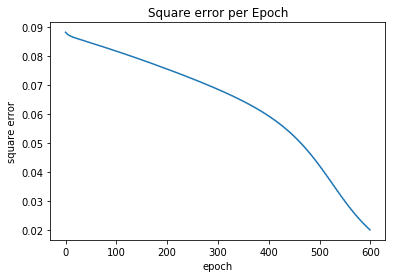

In [255]:
plt.plot(epoch_error)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch')
plt.show()

## Step 5. Predict with the Trained Network
To predict, with our trained network, all we need to do is to propagate forward the input. The result, is the probability that the class to which the input belong is 1.

In [256]:
# Make a prediction with the trained  network
def predict(network, inputs):
    
    if isinstance(inputs, list):
        outputs = []
        for i in range(len(inputs)):
            outputs.append(forward_propagate(network, inputs[i]))
        return outputs
    
    if isinstance(inputs, np.ndarray):   
        
        outputs=np.zeros((inputs.shape[0]), dtype=np.float)
        for i in range(inputs.shape[0]):
            outputs[i] = forward_propagate(network, inputs[i])
        return outputs
   
    outputs = forward_propagate(network, inputs)
    return outputs

In [257]:
prediction = predict(network, np.array(train_set))
for i in range(4):
    print('input:',train_set[i], 'true lable:', targets[i],
          'prediction:', prediction[i])

input: [1, 0.0, 0] true lable: 0 prediction: 0.324927343556
input: [1.0, 0.0, 1.0] true lable: 1 prediction: 0.861188041071
input: [1, 1.0, 1.0] true lable: 1 prediction: 0.895565193638
input: [1.0, 1.0, 0] true lable: 1 prediction: 0.856427069725


## Same Network, learn different problem
One the strongest advantages of neural networks, is the ability to solve different problems with the same network.

Lets train our network, to solve a completely different problem. For that we will use make_moons sklearn function, that create 2 dimensional binary classification dataset, where each class have a 2D moon shape.

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

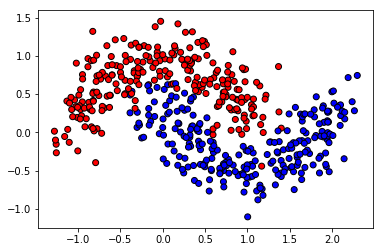

In [259]:
figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
X, y = make_moons(n_samples=500,noise=0.2, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')
    

#### Prepare Train Test Data
* Normalize the data
* Add 1 to input data for the bias
* Split the data

In [260]:
X = StandardScaler().fit_transform(X)
X= np.append(np.ones((X.shape[0],1)), X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, 
                                                    random_state=42)
X_train.shape


(300, 3)

In [262]:
np.random.seed(0)

network = initialize_mlp()
epoch_error = train_network(network=network, x_train=X_train,
                            y_train=y_train,
                            l_rate=0.01, n_epoch=50)


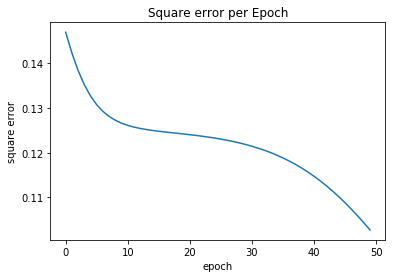

In [263]:
plt.plot(epoch_error)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch')
plt.show()

In [264]:
pred_train = predict(network, X_train)
pred_train[0:5]

array([ 0.566,  0.449,  0.571,  0.476,  0.65 ])

In [265]:
y_train_pred = np.where(pred_train > 0.5, 1, 0)
y_train_pred[0:15], y_train[0:15]

(array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0], dtype=int64))

In [266]:
accuracy_score(y_train, y_train_pred)

0.85333333333333339

Pay attention, the network is trained according to the probability output. Accuracy is calculated, after classifying by applying a threshold decision.

In [267]:
mse_train = ((y_train-pred_train)**2).sum()*1./y_train.shape[0]
mse_train

0.20374773421969267

## Step 6. Evaluate the network
Predict and evaluate on test set

In [268]:
pred_test = predict(network, X_test)
y_test_pred = np.where(pred_test > 0.5, 1, 0)
y_test_pred[0:15], y_test[0:15]

(array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]),
 array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int64))

In [269]:
accuracy_score(y_test, y_test_pred)

0.84499999999999997

In [270]:
mse_test = ((y_test-pred_test)**2).sum()*1./(2.*y_test.shape[0])
mse_test

0.10401780253536304

## Learning rate hyper parameter
Learning rate, the size of each step, influence learning. 
* Large learning rate, can converge faster, since steps are bigger. But minimum can be missed, with steps which are too large.
* Small learning can be more precise, but can get stuck in local minimum, and take very long time to converge.

Lets view few learning rate with sklearn generated circles classification example.

In [271]:
n_epoch=1000

np.random.seed(0)
network = initialize_mlp()
epoch_error_5 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.5, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.5', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_1 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.1, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.1', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_0001 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.01, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.01', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_000001 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.001, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.001', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))


TypeError: train_network() got an unexpected keyword argument 'targets'

In [ ]:
figure = plt.figure(figsize=(12,5))
plt.plot(epoch_error_5)
plt.plot(epoch_error_1)
plt.plot(epoch_error_0001)
plt.plot(epoch_error_000001)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch, with different learning rate')
plt.legend(['alpha=0.5', 'alpha=0.1','alpha=0.01', 'alpha=0.001'], title="Learning Rate")
plt.show()

Lets enlarge dataset size. view the influence

In [ ]:
figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
X, y = make_circles(n_samples=1000,noise=0.1, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

In [ ]:
X = StandardScaler().fit_transform(X)
X= np.append(np.ones((X.shape[0],1)), X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, 
                                                    random_state=42)
X_train.shape


In [ ]:
np.random.seed(0)
n_epoch=300

network = initialize_mlp()
epoch_error_1 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=1., n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=1.', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))


network = initialize_mlp()
epoch_error_05 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.5, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.5', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

network = initialize_mlp()
epoch_error_01 = train_network(network=network, x_train=X_train,
                            targets=y_train,
                            l_rate=0.1, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.1', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))


In [ ]:
figure = plt.figure(figsize=(12,5))
plt.plot(epoch_error_1)
plt.plot(epoch_error_05)
plt.plot(epoch_error_01)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch, with different learning rate')
plt.legend(['alpha=1.','alpha=0.5', 'alpha=0.1'], title="Learning Rate")
plt.show()

## Gradient descent variations  
There are few ways to update the weights. 
### Stochastic Gradient Descent
Stochastic gradient descent, often abbreviated as SGD, is the error we calculated. The weights are updated for each example in the training dataset. The Stochastic is since we shuffle the input set in each iteration.

### Batch Gradient Descent or Full Gradient Descent
In Batch gradient descent the error is calculated for each example in the training dataset, but the weights are updated after a pass on all training examples.

In [ ]:
# Backpropagate error and update weights
def backward_propagate_error_batch(network, I, y_true, y, lr = 0.5):

    m=I.shape[0]
    for i in range(n_hidden):

        # calculate update for output layer weights
        update_i = np.dot(delta(y).T, (y_true - y))* network['hidden_out'][i]
               
        # update hidden layer weights        
        for j in range(n_inputs):
            w_i = network['output_layer_weights'][i]
            y_hi = network['hidden_out'][i]
            update_ij = 0.
            for k in range(m):
                update_ij += update_i*w_i*delta(y_hi)*I[k,j]
            
            network['hidden_layer_weights'][i][j] += lr*update_ij*(1./m)
       
        # update output layer weights
        network['output_layer_weights'][i] +=  lr * update_i  *(1./m)      

In [ ]:
def train_network_batch_GD(network, x_train, y_true, l_rate, n_epoch, verbose=0):
    
    epoch_error = []
    m = x_train.shape[0]
    
    for epoch in range(n_epoch):
        sum_error = 0
        
        outputs = predict(network, x_train)
        
        sum_error = np.dot((target-outputs)**2, (y_true-outputs)**2)

        # update the weights according to error in the output
        backward_propagate_error_batch(network, x_train, y_true, outputs, lr=l_rate)
            
        epoch_error.append(sum_error*(1./(2.*m)))
        if (verbose):
            print('>epoch=%d,  error=%.3f' % (epoch, sum_error))
    return epoch_error

In [ ]:
network = initialize_mlp()
epoch_error = train_network_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.1, n_epoch=50)

In [ ]:
plt.plot(epoch_error)

In [ ]:
np.random.seed(0)
n_epoch=300
network = initialize_mlp()
epoch_error_5 = train_network_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.5, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.5', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_1 = train_network_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.1, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.1', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_0001 = train_network_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.01, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.01', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

In [ ]:
plt.plot(epoch_error_5)
plt.plot(epoch_error_1)
plt.plot(epoch_error_0001)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch, with different learning rate')
plt.legend(['alpha=0.5', 'alpha=0.1','alpha=0.01'], title="Learning Rate")
plt.show()

### Mini-Batch Gradient Descent
In Mini-batch gradient descent we split the training dataset into small batches. The error is calculated ,as a sum or a mean, for each mini batch, and weights are updated after each mini-batch.

We can split the whole data to mini-bathes and go over all of them in each epoch, or we can decide on number of mini-bathes,number of samples in mini-batch, for each epoch.

In [ ]:
def train_network_mini_batch_GD(network, x_train, y_true, l_rate, n_epoch, verbose=0):
    
    epoch_error = []
    m = x_train.shape[0]
    batch_size = 20
    for epoch in range(n_epoch):
        
        x_train,y_true = shuffle(x_train,y_true, random_state=0)
        sum_error = 0
        
        for i in range(0,batch_size*15,batch_size):
            X_i = x_train[i:i+batch_size]
            y_i = y_true[i:i+batch_size]
           
            outputs = predict(network, X_i)
        
            # update the weights according to error in the output
            backward_propagate_error_batch(network, X_i, y_i, outputs, lr=l_rate)
        
        outputs = predict(network, x_train)
        sum_error = np.dot((y_true-outputs)**2, (y_true-outputs)**2)    
        epoch_error.append(sum_error*(1./(2.*m)))
        if (verbose):
            print('>epoch=%d,  error=%.3f' % (epoch, sum_error))
    return epoch_error

In [ ]:
np.random.seed(0)
n_epoch=300
network = initialize_mlp()
epoch_error_5 = train_network_mini_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.1, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.5', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_1 = train_network_mini_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.01, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.1', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

np.random.seed(0)
network = initialize_mlp()
epoch_error_0001 = train_network_mini_batch_GD(network=network, x_train=X_train,
                            y_true=y_train,
                            l_rate=0.001, n_epoch=n_epoch)
pred_test = predict(network, X_test)
print('accuracy for alpha=0.01', accuracy_score(y_test, np.where(pred_test > 0.5, 1, 0)))

In [ ]:
accuracy_score(y_test, np.where(pred_test > 0.6, 1, 0))

In [ ]:
np.where(pred_test > 0.6, 1, 0)

In [ ]:
plt.plot(epoch_error_5)
plt.plot(epoch_error_1)
plt.plot(epoch_error_0001)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch, with different learning rate')
plt.legend(['alpha=0.1', 'alpha=0.01','alpha=0.001'], title="Learning Rate")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [ ]:
print_stats(y_test, np.where(pred_test > 0.5, 1, 0))

As we can see, to build practical neural networks for real problems, 
we better off using deep learning library.
Keras is great library to start with. An illustrative example in the next part.
* https://keras.io/

### Learn more:
* This part was written as an attempt to understand Hinton's lecture: https://www.coursera.org/learn/neural-networks/lecture/bD3OB/learning-the-weights-of-a-linear-neuron-12-min
* Google machine learning course https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent
* https://en.wikipedia.org/wiki/Backpropagation

### Articles:
* D.E. RummelhartG.E. HintonR.J. Williams. **Learning Internal Representations by Error Propagation** Jan 1986 Nature.